In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from src.helpers.data import load_data_to_dataframe, get_data_for_department_business
from src.helpers.computations import get_average, get_weekly_mean
from src.models.enums import MeanType
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [19]:
# Models for comparision
linear_model = LinearRegression()
random_model = RandomForestRegressor(n_estimators=100, max_features=3, random_state=1)

In [20]:
## DATA
trainig_data_frame = load_data_to_dataframe(Path("training_data/train.parquet"))
print(trainig_data_frame.head())
# print("data type and information of the training_data_frame", trainig_data_frame.info())
trainig_data_frame["day_id"] = pd.to_datetime(trainig_data_frame["day_id"])
# print("data type and information of the training_data_frame", trainig_data_frame.info())
bu_feat_data = load_data_to_dataframe(Path("training_data/bu_feat.parquet"))
# print(bu_feat_data.head())
testing_data = load_data_to_dataframe(Path("testing_data/test.parquet"))


       day_id  but_num_business_unit  dpt_num_department     turnover
0  2017-09-30                     64                 127   580.308443
1  2017-09-30                    119                 127  1512.995918
2  2017-09-30                      4                  88   668.593556
3  2017-09-30                    425                 127     0.000000
4  2017-09-30                    513                  73     0.000000


In [21]:
department_number = 117
business_unit = 10

In [22]:
def get_supervised_data(department_number, business_unit):
    filtered_data = get_data_for_department_business(
        data_frame=trainig_data_frame,
        department=department_number,
        business=business_unit,
    )
    data = get_average(data_frame=filtered_data, meantype=MeanType.WEEK)
    data.reset_index(inplace=True)
    supverised_data = data.drop(["day_id"], axis=1)
    return supverised_data, data

      turnover
0  7267.506251
1  3366.325459
2  6157.236717
3  8087.024918
4  5023.560880


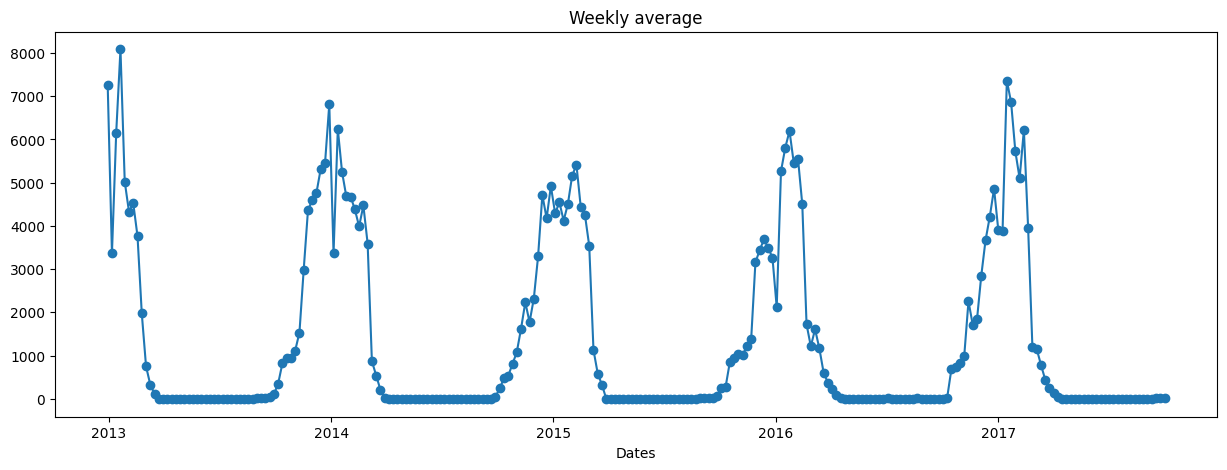

In [23]:
# filter data
supervised_data, data = get_supervised_data(department_number, business_unit)
print(supervised_data.head())
plt.figure(figsize=(15, 5))
plt.plot(data["day_id"],data["turnover"], marker="o")
plt.title( "Weekly average")
plt.xlabel("Dates")
plt.show()

In [24]:
max_look_back = 52 # how many you watch
# BUILD MODEL AND GENERATE METRIC:
r2_linear = []
rmse_linear = []
mae_linear = []

r2_random = []
rmse_random = []
mae_random = []
total_look_back = []
for look_back in range(4, max_look_back):
    total_look_back.append(look_back)
    to_predict = look_back+1
    supverised_data, _ = get_supervised_data(department_number, business_unit)
    # build the supervised leanring dataset
    shifted_columns = [supverised_data]
    for i in range(1, to_predict):
        shifted_columns.append(
            pd.DataFrame({"week_" + str(i): supverised_data["turnover"].shift(i)})
        )
    supverised_data = pd.concat(shifted_columns, axis=1)
    supverised_data = supverised_data.dropna().reset_index(drop=True)
    # create training set and test set
    y_data = supverised_data["turnover"].to_numpy()
    y_data = y_data.reshape(-1, 1)
    x_data = supverised_data.iloc[:, 1:].to_numpy()
    # split ratio 80 - 20
    training_set_length = int(0.8 * len(y_data))
    x_train, x_test, y_train, y_test = (
        x_data[:training_set_length],
        x_data[training_set_length:],
        y_data[:training_set_length],
        y_data[training_set_length:],
    ) 
    random_model.fit(x_train, y_train)
    linear_model.fit(x_train, y_train)
    pred_random = random_model.predict(x_test)
    pred_linear = linear_model.predict(x_test)
    rmse_random.append(np.sqrt(mean_squared_error(pred_random, y_test)))
    rmse_linear.append(np.sqrt(mean_squared_error(pred_linear, y_test)))
    mae_random.append(mean_absolute_error(pred_random, y_test))
    mae_linear.append(mean_absolute_error(pred_linear, y_test))
    r2_random.append(r2_score(pred_random, y_test))
    r2_linear.append(r2_score(pred_linear, y_test))

/Users/krishna/Documents/D&P_DC/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/krishna/Documents/D&P_DC/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/krishna/Documents/D&P_DC/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/krishna/Documents/D&P_DC/.venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vec

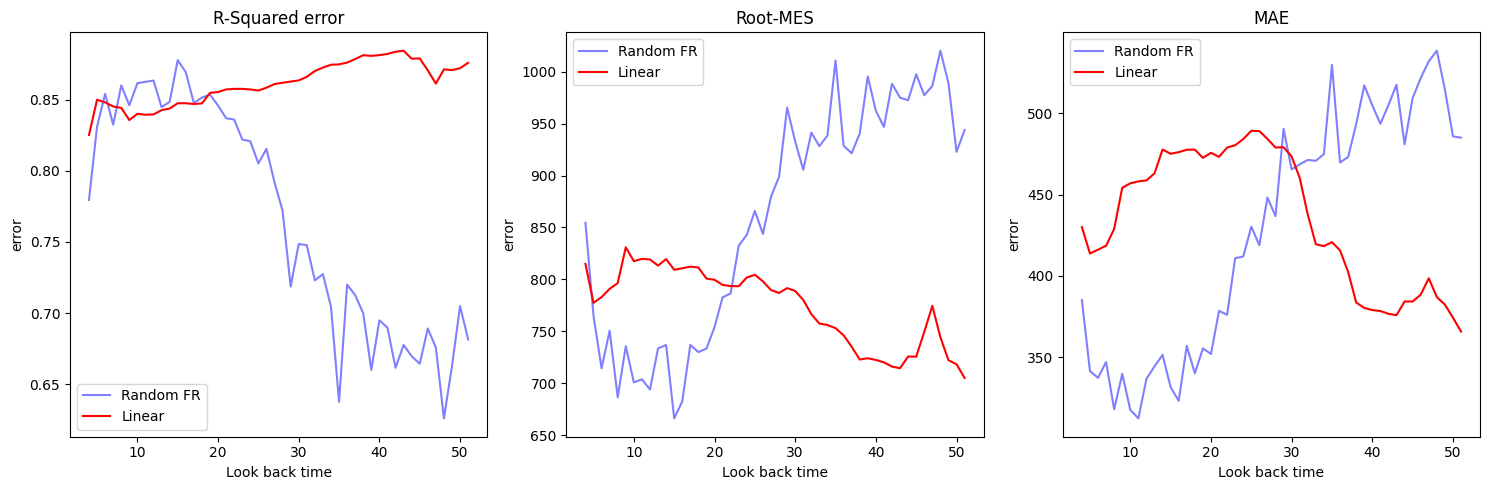

In [25]:


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R2
axes[0].plot(total_look_back,r2_random, color="blue", alpha = 0.5, label = "Random FR")
axes[0].plot(total_look_back, r2_linear, color="red", label = "Linear")
axes[0].legend()
axes[0].set_title("R-Squared error")
axes[0].set_xlabel("Look back time")
axes[0].set_ylabel("error")
# RMSE
axes[1].plot(total_look_back, rmse_random, color="blue", alpha=0.5, label="Random FR")
axes[1].plot(total_look_back, rmse_linear, color="red", label="Linear")
axes[1].legend()
axes[1].set_title("Root-MES")
axes[1].set_xlabel("Look back time")
axes[1].set_ylabel("error")
# MAE
axes[2].plot(total_look_back, mae_random, color="blue", alpha=0.5, label="Random FR")
axes[2].plot(total_look_back, mae_linear, color="red", label="Linear")
axes[2].legend()
axes[2].set_title("MAE")
axes[2].set_xlabel("Look back time")
axes[2].set_ylabel("error")
plt.tight_layout()
plt.show()

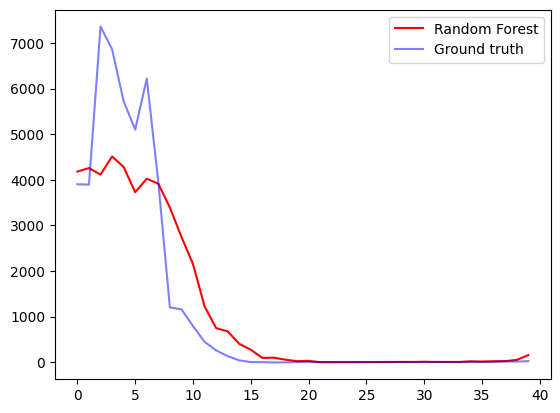

Linear Regression RMSE:  943.8144283497048
Linear Regression MAE:  485.06359807506806
Linear Regression R2 Score:  0.6815690224329556


In [26]:
pred_random = random_model.predict(x_test)
plt.plot(pred_random, label="Random Forest", color="red")
plt.plot(y_test, label="Ground truth", color="blue", alpha=0.5)
plt.legend()
plt.show()
print("Linear Regression RMSE: ", np.sqrt(mean_squared_error(pred_random, y_test)))
print("Linear Regression MAE: ", mean_absolute_error(pred_random, y_test))
print("Linear Regression R2 Score: ", r2_score(pred_random, y_test))

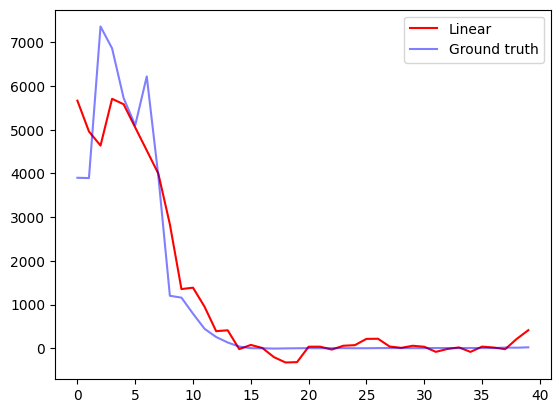

Linear Regression RMSE:  705.0551818870945
Linear Regression MAE:  365.7446188314733
Linear Regression R2 Score:  0.8757954681015199


In [27]:
pred_linear = linear_model.predict(x_test)
plt.plot(pred_linear, label="Linear", color = "red")
plt.plot(y_test, label="Ground truth", color = "blue", alpha = 0.5)
plt.legend()
plt.show()
print("Linear Regression RMSE: ", np.sqrt(mean_squared_error(pred_linear, y_test)))
print("Linear Regression MAE: ", mean_absolute_error(pred_linear, y_test))
print("Linear Regression R2 Score: ", r2_score(pred_linear, y_test))